## Download dataset

In [1]:
from google.colab import files

In [2]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"favourukasoanya","key":"3f7542650efacdb4e7fc870cef5a8ee6"}'}

In [3]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Aug  4 13:38 kaggle.json


In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!pwd

/content


In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets list

ref                                                         title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
nelgiriyewithana/countries-of-the-world-2023                Global Country Information Dataset 2023              23KB  2023-07-08 20:37:33           7709        285  1.0              
alphiree/cardiovascular-diseases-risk-prediction-dataset    Cardiovascular Diseases Risk Prediction Dataset       5MB  2023-07-03 12:12:19           7605        273  1.0              
arnavsmayan/netflix-userbase-dataset                        Netflix Userbase Dataset                             25KB  2023-07-04 07:38:41           9201        166  1.0              
joebeachcapital/top-10000-spotify-songs-1960-now            Top 10000 Songs on S

In [7]:
# Download Kaggle Dataset LFW-People (Face Recognition)
!kaggle datasets download -d atulanandjha/lfwpeople

 99% 231M/232M [00:12<00:00, 20.1MB/s]
100% 232M/232M [00:12<00:00, 18.9MB/s]


## Prep the Data

In [8]:
import numpy as np
import os
from pathlib import Path
from zipfile import ZipFile
import tarfile

### Extract the Data

In [9]:
file_path = '/content/lfwpeople.zip'
with ZipFile(file_path, 'r') as f:
  f.extractall('/content/lfwpeople')

In [10]:
file_path = '/content/lfwpeople/lfw-funneled.tgz'
with tarfile.open(file_path, 'r') as f:
  f.extractall('/content/lfwpeople/lfw-funneled')

In [11]:
data_dir = '/content/lfwpeople/lfw-funneled/lfw_funneled'
len(os.listdir(data_dir))

5760

### Create a Dataloader

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [13]:
data_path = Path(data_dir)

X_dir = sorted([str(data_path / p / sorted(os.listdir(data_path / p))[0]) for p in os.listdir(data_path) if not os.path.isfile(data_path / p) and len(os.listdir(data_path / p)) > 1])
X1_dataset = tf.data.Dataset.from_tensor_slices(X_dir)
X2_dataset = tf.data.Dataset.list_files(data_dir + '/*/*0002.jpg', shuffle=False)
dataset = tf.data.Dataset.zip((X1_dataset, X2_dataset)).shuffle(1024)

In [14]:
len_data = len(X1_dataset)
print(len_data)

1680


In [15]:
def label_image(path):
  return tf.strings.split(path, os.path.sep)[-2] #path.split('/')[-2]

In [16]:

def process(path):
  label = label_image(path)
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  # img = tf.image.convert_image_dtype(img, tf.float32)
  img = img/255
  img = tf.image.resize(img, (250, 250))

  return img, label

In [17]:
def process_pair(X1_path, X2_path):
  # we don't need the label in our workflow, but its good to know we have them.

  x1_img, x2_label = process(X1_path)
  x2_img, x2_label = process(X2_path)

  return x1_img, x2_img

In [18]:
dataset = dataset.map(process_pair)

In [19]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None))>

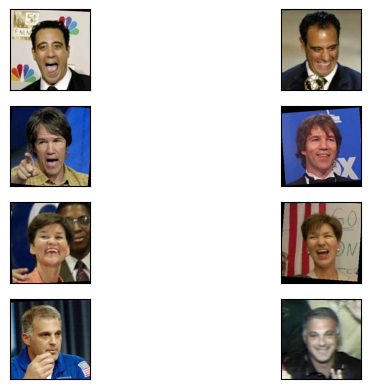

In [20]:
## Test it out (run this block multiple times to see multiple combinations)

fig, axes = plt.subplots(4, 2)

for (x1_img, x2_img), ax in zip(dataset.shuffle(200).take(4).as_numpy_iterator(), axes):
  # print('X1: ', x1_img.dtype)
  # print('X2: ', x2_img.dtype)
  ax[0].get_xaxis().set_visible(False)
  ax[0].get_yaxis().set_visible(False)
  ax[1].get_xaxis().set_visible(False)
  ax[1].get_yaxis().set_visible(False)
  ax[0].imshow(x1_img)
  ax[1].imshow(x2_img)


In [21]:
# Using tf.data.Dataset with functional keras model API requires that we account for labels.
# Although we dont need labels in our workflow, we will add redundant values

redundant_list = [0,] * len_data
redundant_data = tf.data.Dataset.from_tensor_slices(redundant_list)
# dataset = tf.data.Dataset.zip((dataset, redundant_data)).shuffle(1024)

In [22]:
dataset

<_MapDataset element_spec=(TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(250, 250, 3), dtype=tf.float32, name=None))>

In [23]:
# Let's split into train/validation set
train_size = 0.7
dataset_size = len(dataset)
train_dataset = dataset.take(int(train_size * dataset_size))
validation_dataset = dataset.skip(int(train_size * dataset_size))

## Now let's render the data in batches of size 32 per batch
train_dataset = train_dataset.batch(32, drop_remainder=False).prefetch(8)
validation_dataset = validation_dataset.batch(32, drop_remainder=False).prefetch(8)

In [24]:
# Let's confirm the data_generator

for data in train_dataset.take(1).as_numpy_iterator():
  print(len(data[0][0]), len(data[0][1]))

250 250


## The Model

In [25]:
# Import dependacies

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import optimizers, metrics
from tensorflow.keras.applications import resnet

### Build embeddings model

In [26]:
def embedding_model(input_shape):
  base_model = resnet.ResNet50(weights="imagenet", input_shape=input_shape, include_top=False)

  flatten = layers.Flatten()(base_model.output)
  dense1 = layers.Dense(512)(flatten)
  dense1 = layers.LeakyReLU()(dense1)
  dense1 = layers.BatchNormalization()(dense1)
  dense2 = layers.Dense(256)(dense1)
  dense2 = layers.LeakyReLU()(dense2)
  dense2 = layers.BatchNormalization()(dense2)
  output = layers.Dense(256, activation="relu")(dense2)

  embedding = Model(base_model.input, output, name="Embedding")

  trainable = False
  for layer in base_model.layers:
      if layer.name == "conv5_block1_out":
          trainable = True
      layer.trainable = trainable

  return embedding


In [27]:
input_shape = (250, 250, 3)
embedding = embedding_model(input_shape)

94765736/94765736 [==============================] - 6s 0us/step


### Create a Siamese Twim Model form the Embedding Model Using The Functional API

In [28]:
class SimilarityLayer(layers.Layer):
  """
  layer to evaluate the cosine similarity between two vectors
  """
  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, vec_1, vec_2):
    similarity = tf.reduce_sum(tf.square(vec_1 - vec_2), -1)
    return similarity


In [29]:
input_1 = layers.Input(name='input_1', shape=input_shape)#, dtype=tf.float32)
input_2 = layers.Input(name='input_2', shape=input_shape)#, dtype=tf.float32)

tower_1 = embedding(resnet.preprocess_input(input_1))
tower_2 = embedding(resnet.preprocess_input(input_2))

# for training
siamese_learn = Model(inputs=[input_1, input_2], outputs=[tower_1, tower_2])

# the complete model with the final similarity layer
similarity = SimilarityLayer()(tower_1, tower_2)
siamese_model = Model(inputs=[input_1, input_2], outputs=similarity)

In [59]:
# The cost function

def triplet_loss_fn(X1, X2, margin):
    # take a dot product (cosine similarity) of the embedding vectors to get a matrix
    # the diagonals represent duplicate vectors
    # calculate the mean negative (mean of all off-diagonal values in each row)
    # identify the closest negative (off diagonal value closest too but less than the
    #                                diagonal for each row)

    # L1 = max(mean_neg - s(A,P) + margin, 0)
    # L2 = max(closest_neg - s(A,P) + margin, 0)
    # Loss = L1 + L2

    # X1 = X[0]
    # X2 = X[1]

    # print(X1, X1.dtype)
    # print(X2, X2.dtype)
    # print(X2[0], X2[0].dtype)
    # print(X2[1], X2[1].dtype)

    # X1 = tf.cast(X1, tf.float32)
    # X2 = tf.cast(X2, tf.float32)

    # scores = tf.tensordot(X1, X2, 1)
    # scores = tf.reduce_sum(tf.multiply(X1, X2), axis=0)

    batch_size = len(X1)
    scores = tf.matmul(X1, tf.transpose(X2))

    # print(scores)

    positives = tf.linalg.diag_part(scores)

    scores_without_positives = scores * (1 - tf.eye(batch_size))

    mean_negatives = tf.math.reduce_sum(scores_without_positives, axis=1) / (batch_size - 1)

    scores_minimize_positives = scores - 2 * tf.eye(batch_size)

    closest_negatives = tf.math.reduce_max(scores_minimize_positives, axis=1)

    triplet_loss_1 = tf.math.maximum(mean_negatives - positives + margin, 0)

    triplet_loss_2 = tf.math.maximum(closest_negatives - positives + margin, 0)

    triplet_loss = tf.math.reduce_mean(triplet_loss_1 + triplet_loss_2)

    return triplet_loss

In [60]:
from functools import partial

def TripletLoss(margin=0.5):
  loss_fn = partial(triplet_loss_fn, margin=margin)
  return loss_fn

In [61]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None))>

In [62]:
# siamese_learn.compile(loss=TripletLoss(), optimizer=optimizers.Adam(0.0001))
# history = siamese_learn.fit(train_dataset, epochs=10, validation_data=validation_dataset)

### To Accomodate our Wrokflow we'll use a Custom Training Loop

In [63]:
optimizer = optimizers.Adam(0.0001)
loss_fn = TripletLoss()
batch_size = 32
epochs = 10

for epoch in range(epochs):
  print(f'Start of epoch {epoch}')

  # iterate over the batches of the dataset
  for step, (X1, X2) in enumerate(train_dataset):
    # Open a GradientTape to record the operations and enable auto-differenciation
    with tf.GradientTape() as tape:
      # Get logits for this minibatch
      X1_embed, X2_embed = siamese_learn((X1, X2), training=True)

      # print(X1_embed)
      # print(X2_embed)

      # Compute the loss for this minibatch
      loss_value = loss_fn(X1_embed, X2_embed)

    # Retrieve gradients using gradient tape
    grads = tape.gradient(loss_value, siamese_learn.trainable_weights)

    # gradient descent to minimize the loss
    optimizer.apply_gradients(zip(grads, siamese_learn.trainable_weights))

    # Log every 100 batches
    if step % 100 == 0:
      print(f"Training loss (for one batch) at step {step}: {loss_value:.4f}")
      print(f"Seen so far: {(step+1) * batch_size} samples")



Start of epoch 0
Training loss (for one batch) at step 0: 28.8553
Seen so far: 32 samples
Start of epoch 1
Training loss (for one batch) at step 0: 8.9515
Seen so far: 32 samples
Start of epoch 2
Training loss (for one batch) at step 0: 5.3633
Seen so far: 32 samples
Start of epoch 3
Training loss (for one batch) at step 0: 2.7411
Seen so far: 32 samples
Start of epoch 4
Training loss (for one batch) at step 0: 1.9591
Seen so far: 32 samples
Start of epoch 5
Training loss (for one batch) at step 0: 1.8550
Seen so far: 32 samples
Start of epoch 6
Training loss (for one batch) at step 0: 1.3947
Seen so far: 32 samples
Start of epoch 7
Training loss (for one batch) at step 0: 1.1550
Seen so far: 32 samples
Start of epoch 8
Training loss (for one batch) at step 0: 1.0183
Seen so far: 32 samples
Start of epoch 9
Training loss (for one batch) at step 0: 0.6685
Seen so far: 32 samples


In [38]:
a = a = tf.constant([1, 2, 3, 4, 5, 6], shape=[2, 3])
b = tf.constant([7, 8, 9, 10, 11, 12], shape=[2, 3])

In [39]:
a, b

(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[1, 2, 3],
        [4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
 array([[ 7,  8,  9],
        [10, 11, 12]], dtype=int32)>)

In [54]:
scores = tf.tensordot(a, tf.transpose(b), 1)
# scores = tf.reduce_sum(tf.multiply(a, b), axis=0)
# scores = tf.matmul(a, tf.transpose(b))

scores

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 50,  68],
       [122, 167]], dtype=int32)>